In [1]:
import pandas as pd
import numpy as np
import gmaps
import requests
from config import gkey
from pprint import pprint
import re
import scipy.stats as stats
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
gmaps.configure(api_key=gkey)

In [3]:
small_parking = pd.read_csv('los-angeles-parking-citations/small_parking-citations.csv')
small_parking.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2,8939,WHITE CURB,58.0,6439997.9,1802686.4
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,WH,100 WORLD WAY,2F11,2,000,17104h,NaN,6440041.1,1802686.2
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0


In [4]:
# Add 'Los Angeles' to all addresses to column 'City Address' to produce results just from LA area 

small_parking['City Address'] = small_parking['Location'].apply(lambda x: f"{x}, Los Angeles, CA")

In [5]:
# Create new columns for the new lat and long data, formatted address and zip code that will be added from
# api call

small_parking["New Lat"] =''
small_parking['New Long'] = ''
small_parking['Format Address'] = ''
small_parking['Zip Code'] = ''

In [6]:
# Reduce the columns down to data that I need for analysis
geo_small_parking = small_parking[["Ticket number",'City Address', 'Fine amount', 'New Lat', "New Long", 'Zip Code', 'Format Address']]
geo_small_parking.shape

(999, 7)

In [7]:
geo_small_parking.head()

,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
0,1103341116,"13147 WELBY WAY, Los Angeles, CA",50.0,,,,
1,1103700150,"525 S MAIN ST, Los Angeles, CA",50.0,,,,
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,,,,
3,1104820732,"100 WORLD WAY, Los Angeles, CA",NaN,,,,
4,1105461453,"GEORGIA ST/OLYMPIC, Los Angeles, CA",93.0,,,,


In [8]:
# Dropping NaN's from 'City Address' to get exact and true lat and long coordinates 
no_nans2 = geo_small_parking.dropna(subset=['City Address'])

In [9]:
# Check to see if there are any nans
no_nans2["City Address"].isnull().sum()

0

In [10]:
# For loop to get lat and long coordinates and the formatted address to be used for zip codes, insert them into 
# the data frame
for index, row in no_nans2.iterrows():

    # Get the address from dataframe
    address = row['City Address']
    
    # Build the url and gkey
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
    'address={0}&key={1}').format(address, gkey)


    # assemble url and make API request
    response = requests.get(target_url).json()
    
    # Use a Try/Except to get lat and long and format address
    try:
        # Extract latitude and longitude
        lat = response["results"][0]["geometry"]["location"]["lat"]
        lng = response["results"][0]["geometry"]["location"]["lng"]
        format_address = response['results'][0]['formatted_address']
        zip = re.findall('\d+', row['Format Address'] )
#         zip = response['results'][0]['formatted_address']
#         print(format_address)
        no_nans2.loc[index, 'New Lat'] = lat
        no_nans2.loc[index, 'New Long'] = lng
        no_nans2.loc[index, 'Format Address'] = format_address
        
        
        # print the lat and long and the index with address to see how far along I am in getting my data
        print(f"Getting latitude of {lat} and longitude {lng} for Index {index} at {address}.")

        # pretty print the response for any error
    except (KeyError, IndexError):
        print(f"Missing field/result {index}: {address}... skipping.")
        pprint(response)
    
# Print statement so I know I'm finished
print("Finished retreiving data")

Getting latitude of 34.1931841 and longitude -118.4198586 for Index 0 at 13147 WELBY WAY, Los Angeles, CA.
Getting latitude of 34.1682442 and longitude -118.3142772 for Index 1 at 525 S MAIN ST, Los Angeles, CA.
Getting latitude of 33.9452814 and longitude -118.4041195 for Index 2 at 200 WORLD WAY, Los Angeles, CA.
Getting latitude of 33.9457447 and longitude -118.4009677 for Index 3 at 100 WORLD WAY, Los Angeles, CA.
Getting latitude of 34.0458826 and longitude -118.2668616 for Index 4 at GEORGIA ST/OLYMPIC, Los Angeles, CA.
Getting latitude of 34.0611926 and longitude -118.2046767 for Index 5 at SAN PEDRO S/O BOYD, Los Angeles, CA.
Getting latitude of 34.0778039 and longitude -118.263145 for Index 6 at SUNSET/ALVARADO, Los Angeles, CA.
Getting latitude of 34.0778039 and longitude -118.263145 for Index 7 at SUNSET/ALVARADO, Los Angeles, CA.
Getting latitude of 34.0554475 and longitude -118.2763928 for Index 8 at 721 S WESTLAKE, Los Angeles, CA.
Getting latitude of 34.0574906 and longi

Getting latitude of 32.1656221 and longitude -82.9000751 for Index 76 at GEORGIA/17TH ST, Los Angeles, CA.
Getting latitude of 34.0522342 and longitude -118.2436849 for Index 77 at 11TH E/O, Los Angeles, CA.
Getting latitude of 34.04972 and longitude -118.2593666 for Index 78 at FIGUEROA N/O VENICE, Los Angeles, CA.
Getting latitude of 34.04972 and longitude -118.2593666 for Index 79 at FIGUEROA N/O VENICE, Los Angeles, CA.
Getting latitude of 34.0422553 and longitude -118.2630689 for Index 80 at HOPE S/O 11TH ST, Los Angeles, CA.
Getting latitude of 33.9875381 and longitude -118.4653645 for Index 81 at 501 S VENICE BLVD, Los Angeles, CA.
Getting latitude of 33.9433006 and longitude -118.4090012 for Index 82 at 380 WORLD WAY U/L, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 83 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 84 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.209209

Getting latitude of 34.20993 and longitude -118.4819101 for Index 151 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 152 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 153 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 154 at 7610 WOODLEY AVE, Los Angeles, CA.
Getting latitude of 34.2051023 and longitude -118.485697 for Index 155 at 7400 BLK VALJEAN, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 156 at 7610 WOODLEY, Los Angeles, CA.
Getting latitude of 34.20993 and longitude -118.4819101 for Index 157 at 7610 WOODLEY, Los Angeles, CA.
Getting latitude of 33.94311280000001 and longitude -118.4092011 for Index 158 at 380 WORLD WAY, Los Angeles, CA.
Getting latitude of 33.9447111 and longitude -118.4037513 for Index 159 at 251 WORLD WAY, Los Angeles, CA.
Getting latitude of 33.9447111

Getting latitude of 33.9518229 and longitude -118.3892321 for Index 226 at 9201 JENNY AV, Los Angeles, CA.
Getting latitude of 33.94192330000001 and longitude -118.4069605 for Index 227 at 400 WORLD WAY L/L, Los Angeles, CA.
Getting latitude of 33.9452814 and longitude -118.4041195 for Index 228 at 200 WORLD WAY 2F, Los Angeles, CA.
Getting latitude of 33.9452814 and longitude -118.4041195 for Index 229 at 200 WORLD WAY 2M, Los Angeles, CA.
Getting latitude of 33.9444181 and longitude -118.4068996 for Index 230 at 301 WORLD WAY 1E, Los Angeles, CA.
Getting latitude of 33.9444181 and longitude -118.4068996 for Index 231 at 301 WORLD WAY 1G, Los Angeles, CA.
Getting latitude of 33.9444181 and longitude -118.4068996 for Index 232 at 301 WORLD WAY 1F, Los Angeles, CA.
Getting latitude of 33.9469524 and longitude -118.3896546 for Index 233 at 6053 CENTURY BLVD, Los Angeles, CA.
Getting latitude of 33.9499046 and longitude -118.3777452 for Index 234 at 6221 W 96TH ST 19A, Los Angeles, CA.
Ge

Getting latitude of 33.9974073 and longitude -118.2800616 for Index 301 at 50TH/GRAND, Los Angeles, CA.
Getting latitude of 33.997786 and longitude -118.2937498 for Index 302 at 50TH W/O MAIN, Los Angeles, CA.
Getting latitude of 33.9950726 and longitude -118.2680795 for Index 303 at 356 E 52 ST, Los Angeles, CA.
Getting latitude of 33.9981722 and longitude -118.3269448 for Index 304 at WALL N/O 50TH, Los Angeles, CA.
Getting latitude of 33.7360619 and longitude -118.2922461 for Index 305 at 57/SAN PEDRO, Los Angeles, CA.
Getting latitude of 34.2032239 and longitude -118.5097152 for Index 306 at 57 E/O BROADWAY, Los Angeles, CA.
Getting latitude of 33.99464870000001 and longitude -118.2426507 for Index 307 at 53/DUARTE, Los Angeles, CA.
Getting latitude of 34.0083268 and longitude -118.2805193 for Index 308 at 41ST PL/W/O MAIN, Los Angeles, CA.
Getting latitude of 34.0057592 and longitude -118.2565086 for Index 309 at 43RD PL E/O BROADWAY, Los Angeles, CA.
Getting latitude of 34.001649

Getting latitude of 34.0246363 and longitude -118.4000909 for Index 376 at 3735 HUGHES AVE, Los Angeles, CA.
Getting latitude of 34.0240419 and longitude -118.4001763 for Index 377 at 3754 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0264755 and longitude -118.4019563 for Index 378 at 3636 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0276931 and longitude -118.4030894 for Index 379 at 3554 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0281371 and longitude -118.4033174 for Index 380 at 3534 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0279635 and longitude -118.4031202 for Index 381 at 3540 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0281149 and longitude -118.4032343 for Index 382 at 3536 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0274642 and longitude -118.4027917 for Index 383 at 3578 DUNN DR, Los Angeles, CA.
Getting latitude of 34.0249357 and longitude -118.4014771 for Index 384 at 10000 REGENT STREET, Los Angeles, CA.
Getting latitude of 34.0249357 and l

Getting latitude of 34.054546 and longitude -118.3940828 for Index 450 at 1420 REXFORD DR, Los Angeles, CA.
Getting latitude of 34.0318748 and longitude -118.4414097 for Index 451 at 2451 COLBY AVE, Los Angeles, CA.
Getting latitude of 34.0319272 and longitude -118.4408037 for Index 452 at 2464 COLBY AVE, Los Angeles, CA.
Getting latitude of 34.0322012 and longitude -118.4409863 for Index 453 at 2452 COLBY AVE, Los Angeles, CA.
Getting latitude of 34.0324216 and longitude -118.4412144 for Index 454 at 2440 COLBY AVE, Los Angeles, CA.
Getting latitude of 34.032131 and longitude -118.4433605 for Index 455 at 2418 FEDERAL AVE, Los Angeles, CA.
Getting latitude of 34.031846 and longitude -118.443658 for Index 456 at 2415 FEDERAL AVE, Los Angeles, CA.
Getting latitude of 34.0529452 and longitude -118.4021389 for Index 457 at 1431 ROXBURY DR, Los Angeles, CA.
Getting latitude of 34.024948 and longitude -118.3991949 for Index 458 at 3739 DELMAS TERRANCE, Los Angeles, CA.
Getting latitude of 3

Getting latitude of 34.2648069 and longitude -118.5066548 for Index 525 at 10700 AMESTOY AVE, Los Angeles, CA.
Getting latitude of 34.2613724 and longitude -118.5027182 for Index 526 at 10515 BALBOA BLVD, Los Angeles, CA.
Getting latitude of 34.2516908 and longitude -118.521799 for Index 527 at 17800 MERRIDY ST, Los Angeles, CA.
Getting latitude of 34.0738399 and longitude -118.373423 for Index 528 at 125 ORLANDO AVE S, Los Angeles, CA.
Getting latitude of 34.0735676 and longitude -118.3733859 for Index 529 at 135 ORLANDO AVE S, Los Angeles, CA.
Getting latitude of 34.0726108 and longitude -118.3711548 for Index 530 at 8330 3RD ST W, Los Angeles, CA.
Getting latitude of 34.0759112 and longitude -118.3640491 for Index 531 at 8000 BEVERLY BL, Los Angeles, CA.
Getting latitude of 34.2121024 and longitude -118.3407615 for Index 532 at 9600 CABRINI DR, Los Angeles, CA.
Getting latitude of 34.2151214 and longitude -118.3380385 for Index 533 at 9500 CABRINI DR, Los Angeles, CA.
Getting latitu

Getting latitude of 34.08506330000001 and longitude -118.3079658 for Index 598 at 821 N OXFORD AVE, Los Angeles, CA.
Getting latitude of 34.0852057 and longitude -118.3084546 for Index 599 at 5016 W INSTITUTE PL, Los Angeles, CA.
Getting latitude of 34.0852056 and longitude -118.3081349 for Index 600 at 5006 W INSTITUTE PL, Los Angeles, CA.
Getting latitude of 34.084676 and longitude -118.30697 for Index 601 at 4955 W MARATHON ST, Los Angeles, CA.
Getting latitude of 34.0848974 and longitude -118.3057586 for Index 602 at 808 MELROSE HILL N, Los Angeles, CA.
Getting latitude of 34.0849596 and longitude -118.3068896 for Index 603 at 4950 MELROSE HILL W, Los Angeles, CA.
Getting latitude of 34.0862661 and longitude -118.3032894 for Index 604 at 4905 W LEMON GROVE AVE, Los Angeles, CA.
Getting latitude of 34.0847516 and longitude -118.3041843 for Index 605 at 743 N HARVARD BLVD, Los Angeles, CA.
Getting latitude of 34.084337 and longitude -118.30428 for Index 606 at 725 N HARVARD BLVD, Los

Getting latitude of 33.9876112 and longitude -118.4727922 for Index 673 at 61 WINDWARD AVE E, Los Angeles, CA.
Getting latitude of 33.9871072 and longitude -118.4714553 for Index 674 at 100 VENICE WAY, Los Angeles, CA.
Getting latitude of 33.9871072 and longitude -118.4714553 for Index 675 at 100 VENICE WAY, Los Angeles, CA.
Getting latitude of 34.0328882 and longitude -118.2631796 for Index 676 at 1700 MAIN ST, Los Angeles, CA.
Getting latitude of 33.9882839 and longitude -118.4718659 for Index 677 at 121 WINDWARD AVE E, Los Angeles, CA.
Getting latitude of 34.0350198 and longitude -118.2619356 for Index 678 at 1401 MAIN ST, Los Angeles, CA.
Getting latitude of 34.0360303 and longitude -118.260337 for Index 679 at 1300 MAIN ST, Los Angeles, CA.
Getting latitude of 33.9884979 and longitude -118.4724185 for Index 680 at 1500 PARK ROW, Los Angeles, CA.
Getting latitude of 33.9884979 and longitude -118.4724185 for Index 681 at 1500 PARK ROW, Los Angeles, CA.
Getting latitude of 33.987687 

Getting latitude of 33.9316791 and longitude -118.2574247 for Index 748 at 932 113TH ST E, Los Angeles, CA.
Getting latitude of 33.929375 and longitude -118.264734 for Index 749 at 609 116TH ST W, Los Angeles, CA.
Getting latitude of 33.9299176 and longitude -118.2626894 for Index 750 at 666 115TH ST E, Los Angeles, CA.
Getting latitude of 33.92671490000001 and longitude -118.2646079 for Index 751 at 613 118TH ST E, Los Angeles, CA.
Getting latitude of 34.0608405 and longitude -118.3395069 for Index 752 at 742 CITRUS AVE S, Los Angeles, CA.
Getting latitude of 34.0679789 and longitude -118.3154416 for Index 753 at 333 VAN NESS AVE S, Los Angeles, CA.
Getting latitude of 34.0678189 and longitude -118.3154416 for Index 754 at 335 VAN NESS AVE S, Los Angeles, CA.
Getting latitude of 34.0674475 and longitude -118.3154873 for Index 755 at 351 VAN NESS AVE S, Los Angeles, CA.
Getting latitude of 34.0672989 and longitude -118.3154416 for Index 756 at 357 VAN NESS AVE S, Los Angeles, CA.
Getti

Getting latitude of 34.0858467 and longitude -118.2833231 for Index 823 at 806 HYPERION AVE N, Los Angeles, CA.
Getting latitude of 34.0876033 and longitude -118.2816473 for Index 824 at 906 HYPERION AVE N, Los Angeles, CA.
Getting latitude of 34.0903377 and longitude -118.2799828 for Index 825 at 1026 HYPERION AVE N, Los Angeles, CA.
Getting latitude of 34.0900591 and longitude -118.282148 for Index 826 at 975 SANBORN AVE N, Los Angeles, CA.
Getting latitude of 34.0888878 and longitude -118.2825133 for Index 827 at 932 VENANGO AVE, Los Angeles, CA.
Getting latitude of 34.0889721 and longitude -118.2824563 for Index 828 at 940 VENANGO AVE, Los Angeles, CA.
Getting latitude of 34.0890492 and longitude -118.2823877 for Index 829 at 942 VENANGO AVE, Los Angeles, CA.
Getting latitude of 34.089141 and longitude -118.2823377 for Index 830 at 944 VENANGO AVE, Los Angeles, CA.
Getting latitude of 34.08154 and longitude -118.2913512 for Index 831 at 590 VERMONT AVE N, Los Angeles, CA.
Getting l

Getting latitude of 33.9878268 and longitude -118.4286094 for Index 898 at 12817 WALSH AVE, Los Angeles, CA.
Getting latitude of 33.9872329 and longitude -118.4306972 for Index 899 at 12908 GREENE AVE, Los Angeles, CA.
Getting latitude of 33.988612 and longitude -118.434855 for Index 900 at 4365 ALLA ROAD, Los Angeles, CA.
Getting latitude of 33.9730024 and longitude -118.3735601 for Index 901 at 7103 RAMSGATE AVE, Los Angeles, CA.
Getting latitude of 33.9751693 and longitude -118.3755734 for Index 902 at 7020 FLIGHT AVE, Los Angeles, CA.
Getting latitude of 33.9844837 and longitude -118.4084374 for Index 903 at 12050 LUCILE AVE, Los Angeles, CA.
Getting latitude of 33.9895995 and longitude -118.4136906 for Index 904 at 12050 HAVELOCK AVE, Los Angeles, CA.
Getting latitude of 34.06718499999999 and longitude -118.2707289 for Index 905 at 2115 BEVERLY BLVD, Los Angeles, CA.
Getting latitude of 34.061669 and longitude -118.279042 for Index 906 at 2501 6TH ST W, Los Angeles, CA.
Getting la

Getting latitude of 34.0269403 and longitude -118.40417 for Index 973 at 3561 CLARINGTON AVE, Los Angeles, CA.
Getting latitude of 34.0251181 and longitude -118.4026638 for Index 974 at 3667 CLARINGTON AVE, Los Angeles, CA.
Getting latitude of 34.02484390000001 and longitude -118.4024812 for Index 975 at 3675 CLARINGTON AVE, Los Angeles, CA.
Getting latitude of 34.0246957 and longitude -118.4014771 for Index 976 at 3718 CLARINGTON AVE, Los Angeles, CA.
Getting latitude of 34.0246957 and longitude -118.4014771 for Index 977 at 3718 CLARINGTON AVE, Los Angeles, CA.
Getting latitude of 34.0214448 and longitude -118.4138134 for Index 978 at 11300 TABOR ST, Los Angeles, CA.
Getting latitude of 34.0550143 and longitude -118.3879892 for Index 979 at 9000 PICO BL W, Los Angeles, CA.
Getting latitude of 34.0622548 and longitude -118.3471728 for Index 980 at 700 COCHRAN AVE, Los Angeles, CA.
Getting latitude of 34.0615517 and longitude -118.3514504 for Index 981 at 5600 WILSHIRE BL, Los Angeles,

In [11]:
# For loop to loop through dataframe using 'Format Address' to get zip into a column
for index, row in no_nans2.iterrows():
#     zip = int(filter(str.isdigit, row['Format Address']))
    # set a variable of the digits for 'Format Address'
    zip = re.findall('\d+', row['Format Address'] )
    
    # Try loop if the length of the zip variable to separate 5 digit zip versus actual zip codes
    try:
        if len(zip[-1]) < 5:
            print(f'zip not long enough{zip}')
        else:
            zip_code = (zip[-1])
            zip_code = int(zip_code)
            no_nans2.loc[index, 'Zip Code'] = zip_code
    # print out what the error was for except if it was blank
    except:
        print(f'Error: {zip}')
    

zip not long enough['11']
Error: []
Error: []
zip not long enough['11']
zip not long enough['11']
Error: []
Error: []
Error: []
Error: []
Error: []
Error: []
Error: []
Error: []
Error: []
zip not long enough['50']
Error: []
zip not long enough['43']
zip not long enough['46']
zip not long enough['55']
Error: []
zip not long enough['55']
Error: []
zip not long enough['62']
Error: []
Error: []
Error: []
Error: []
Error: []
Error: []


In [12]:
# print out my dataframe to see result
no_nans2.head()

,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
0,1103341116,"13147 WELBY WAY, Los Angeles, CA",50.0,34.1932,-118.42,91606,"13147 Welby Way, North Hollywood, CA 91606, USA"
1,1103700150,"525 S MAIN ST, Los Angeles, CA",50.0,34.1682,-118.314,91506,"525 S Main St, Burbank, CA 91506, USA"
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,33.9453,-118.404,90045,"200 World Way, Los Angeles, CA 90045, USA"
3,1104820732,"100 WORLD WAY, Los Angeles, CA",NaN,33.9457,-118.401,90045,"100 World Way, Los Angeles, CA 90045, USA"
4,1105461453,"GEORGIA ST/OLYMPIC, Los Angeles, CA",93.0,34.0459,-118.267,90015,"W Olympic Blvd & Georgia St, Los Angeles, CA 9..."


In [13]:
# replace any blanks with NaN to be dealt with and dropped
clean_geo_nan2 = no_nans2.replace('', np.nan)
clean_geo_nan2.shape

(999, 7)

In [14]:
# Dropping any NaNs 
clean_data_loc_fine2 = clean_geo_nan2.dropna(subset=['New Lat', "New Long", 'Fine amount','Zip Code'])
clean_data_loc_fine2.shape

(959, 7)

In [15]:
clean_data_loc_fine2.head()

,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
0,1103341116,"13147 WELBY WAY, Los Angeles, CA",50.0,34.193184,-118.419859,91606.0,"13147 Welby Way, North Hollywood, CA 91606, USA"
1,1103700150,"525 S MAIN ST, Los Angeles, CA",50.0,34.168244,-118.314277,91506.0,"525 S Main St, Burbank, CA 91506, USA"
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,33.945281,-118.404119,90045.0,"200 World Way, Los Angeles, CA 90045, USA"
4,1105461453,"GEORGIA ST/OLYMPIC, Los Angeles, CA",93.0,34.045883,-118.266862,90015.0,"W Olympic Blvd & Georgia St, Los Angeles, CA 9..."
5,1106226590,"SAN PEDRO S/O BOYD, Los Angeles, CA",50.0,34.061193,-118.204677,90089.0,"1441 Eastlake Ave, Los Angeles, CA 90089, USA"


In [16]:
# Set variables for HeatMap
locations = clean_data_loc_fine2[['New Lat', 'New Long']]
weights = clean_data_loc_fine2['Fine amount']

In [17]:
# Figure for HeatMap
fig = gmaps.figure(zoom_level = 10.5, center=(34.0522, -118.2437))

heat_layer = gmaps.heatmap_layer(locations, weights=weights, 
                                 dissipating=False, max_intensity=20,
                                 point_radius = 1)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 100
heat_layer.point_radius = .003

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Api request for zip code coordinates
url = 'https://opendata.arcgis.com/datasets/09f503229d37414a8e67a7b6ceb9ec43_7.geojson'
response = requests.get(url).json()

# Build a dataframe for response
lat_long_city_boundaries = pd.DataFrame(response['features'][0]['geometry']['coordinates'][0])

# Flip the columns so its in lat long order
lat_long_flip_city_boundaries = lat_long_city_boundaries.iloc[:, ::-1]
lat_long_flip_city_boundaries.head()

,1,0
0,34.329169,-118.419998
1,34.329168,-118.419477
2,34.329885,-118.419474
3,34.329885,-118.419022
4,34.329648,-118.418872


In [19]:
# Build a list of tuples for boundaries values
la_city_boundaries = [tuple(r) for r in lat_long_flip_city_boundaries.values]

In [20]:
# Gmaps city boundaries
fig = gmaps.figure(zoom_level= 9, center=(34.0522, -118.2437))
la_city_boundaries_polygon = gmaps.Polygon(la_city_boundaries, stroke_color='red')
city_drawing = gmaps.drawing_layer(features=[la_city_boundaries_polygon],show_controls=False)
fig.add_layer(city_drawing)

fig

Figure(layout=FigureLayout(height='420px'))

In [21]:
# Layer HeatMap and City Boundaries
fig.add_layer(heat_layer)
fig.add_layer(city_drawing)

fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
clean_data_loc_fine2.head()

,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
0,1103341116,"13147 WELBY WAY, Los Angeles, CA",50.0,34.193184,-118.419859,91606.0,"13147 Welby Way, North Hollywood, CA 91606, USA"
1,1103700150,"525 S MAIN ST, Los Angeles, CA",50.0,34.168244,-118.314277,91506.0,"525 S Main St, Burbank, CA 91506, USA"
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,33.945281,-118.404119,90045.0,"200 World Way, Los Angeles, CA 90045, USA"
4,1105461453,"GEORGIA ST/OLYMPIC, Los Angeles, CA",93.0,34.045883,-118.266862,90015.0,"W Olympic Blvd & Georgia St, Los Angeles, CA 9..."
5,1106226590,"SAN PEDRO S/O BOYD, Los Angeles, CA",50.0,34.061193,-118.204677,90089.0,"1441 Eastlake Ave, Los Angeles, CA 90089, USA"


In [23]:
# Clean Zip Code as an integer for formatting
clean_data_loc_fine2.loc[:,'Zip Code'] = clean_data_loc_fine2.loc[:,'Zip Code'].astype(int)
clean_data_loc_fine2.head()

/Users/kevinheaney/anaconda3/envs/WashU/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
0,1103341116,"13147 WELBY WAY, Los Angeles, CA",50.0,34.193184,-118.419859,91606,"13147 Welby Way, North Hollywood, CA 91606, USA"
1,1103700150,"525 S MAIN ST, Los Angeles, CA",50.0,34.168244,-118.314277,91506,"525 S Main St, Burbank, CA 91506, USA"
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,33.945281,-118.404119,90045,"200 World Way, Los Angeles, CA 90045, USA"
4,1105461453,"GEORGIA ST/OLYMPIC, Los Angeles, CA",93.0,34.045883,-118.266862,90015,"W Olympic Blvd & Georgia St, Los Angeles, CA 9..."
5,1106226590,"SAN PEDRO S/O BOYD, Los Angeles, CA",50.0,34.061193,-118.204677,90089,"1441 Eastlake Ave, Los Angeles, CA 90089, USA"


In [24]:
clean_data_loc_fine2.nunique()

Ticket number     959
City Address      779
Fine amount        12
New Lat           725
New Long          713
Zip Code           85
Format Address    752
dtype: int64

In [25]:
# Groupby zip codes
zip_group = clean_data_loc_fine2.groupby(['Zip Code'])

In [26]:
# Sum all total fines in each Zip Code
zip_fine_totals = zip_group['Fine amount'].sum()

In [27]:
zip_chi_totals = pd.DataFrame({'Fine Total Amount': zip_fine_totals})
zip_chi_totals.head()

,Fine Total Amount
Zip Code,
90003,903.0
90004,1230.0
90005,2006.0
90006,395.0
90007,998.0


In [28]:
# Variable for fine amounts
fine_amounts = zip_chi_totals['Fine Total Amount']

### Visual aide bar chart for fine amounts of all zip codes. Red average line to show variation in fine amounts


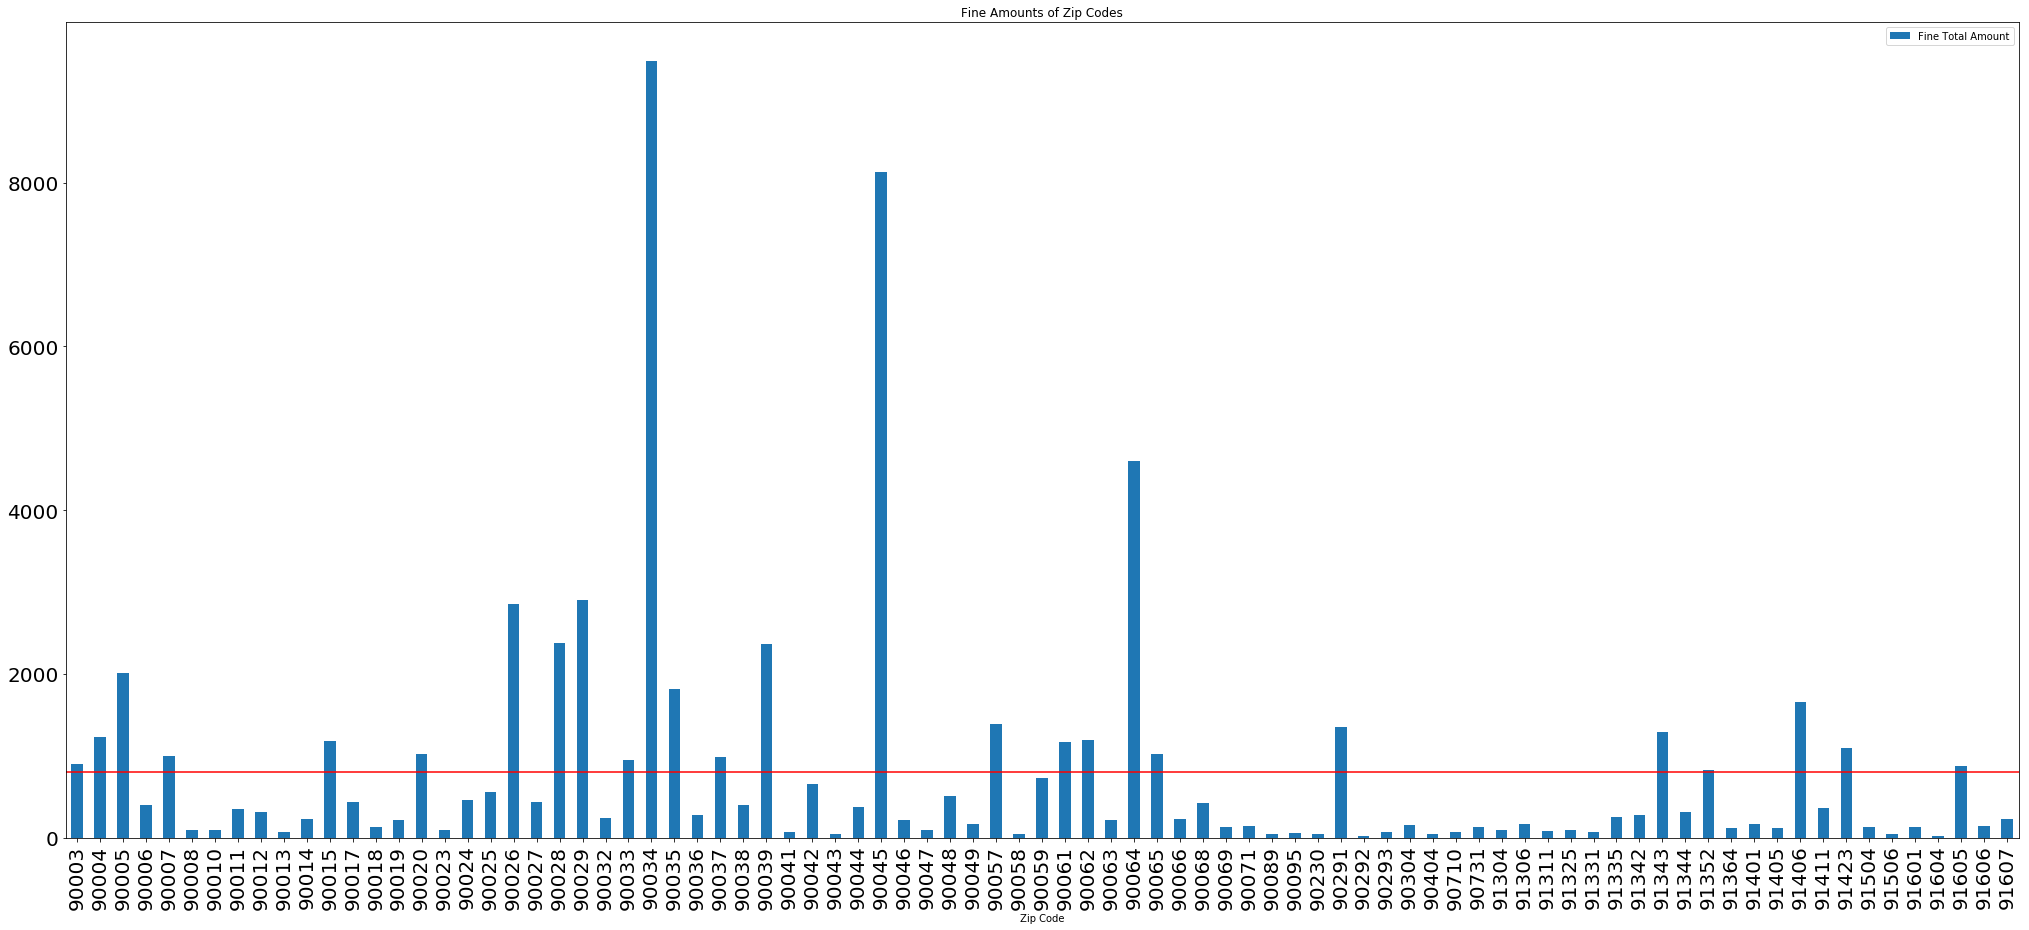

In [29]:
# Bar chart for fine amounts with average line to show that 
fig,ax= plt.subplots()
zip_chi_totals.plot(kind='bar', ax = ax, title = 'Fine Amounts of Zip Codes',figsize=(35,15), fontsize = 20)

mean = zip_chi_totals["Fine Total Amount"].mean()

ax.axhline(mean, color = 'red')
plt.savefig('Zip_code_Fines_bar_chart.png')

In [30]:
# Count number of fines
zip_fine_counts = zip_group['Fine amount'].count()

In [31]:
# Build a dataframe for fine counts
zip_chi_counts = pd.DataFrame({'Fine Count': zip_fine_counts})
zip_chi_counts.head()

,Fine Count
Zip Code,
90003,12
90004,24
90005,31
90006,5
90007,11


In [32]:
# Variable for fine counts
fine_count = zip_chi_counts['Fine Count']

### Visual aide bar chart for fine counts of all zip codes. Green average line to show variation in fine counts 

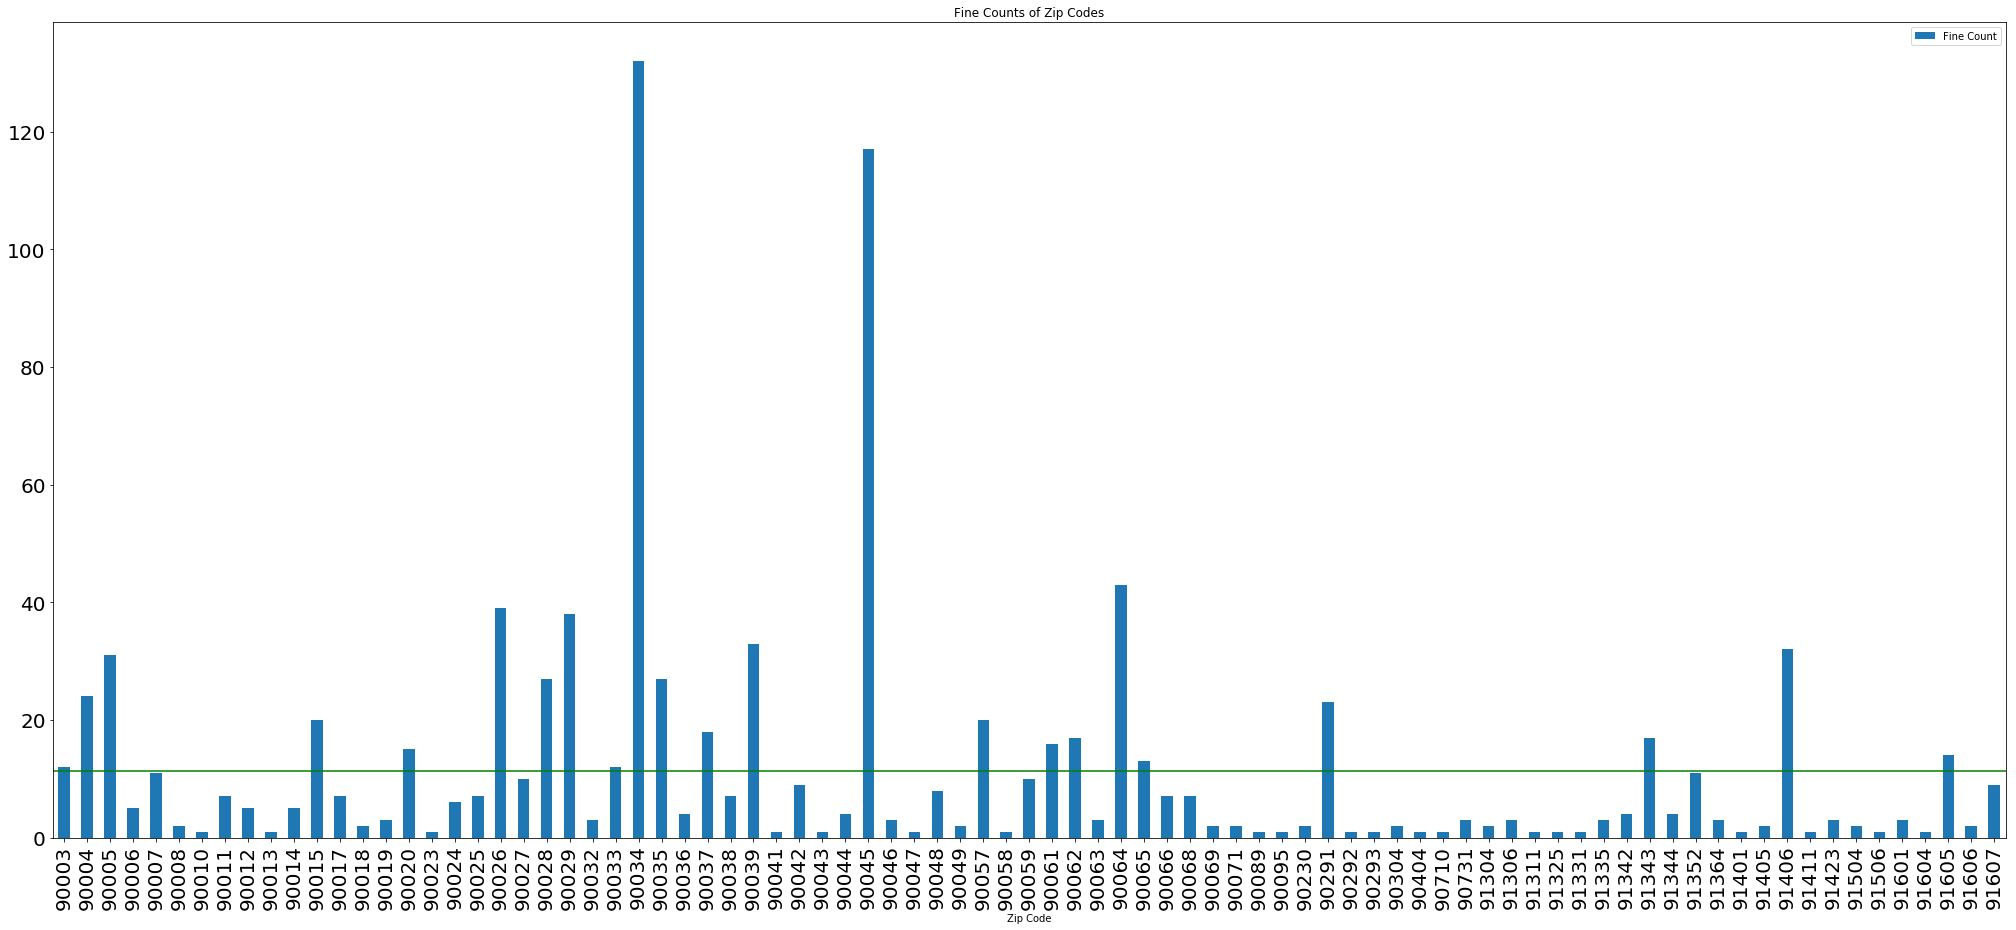

In [33]:
# Bar chart for fine amounts with average line to show that 
fig,ax= plt.subplots()
zip_chi_counts.plot(kind='bar', ax = ax, title = 'Fine Counts of Zip Codes',figsize=(35,15), fontsize = 20)

mean = zip_chi_counts["Fine Count"].mean()

ax.axhline(mean, color = 'green')
plt.savefig('Zip_code_counts_bar_chart.png')

# Chi Squared Test

## Question: Are certain zip codes worse and therefore you are more likely to get a ticket in a zip code?

In [34]:
# Create a variable for count of zip codes
zip_count = zip_chi_counts['Fine Count'].count()
zip_count

85

In [35]:
# Sum all counts of fines
zip_total = zip_chi_counts["Fine Count"].sum()
zip_total

959

In [36]:
# create variable for expected fine counts
expected_fine_count = zip_total/zip_count
expected_fine_count

11.282352941176471

In [37]:
zip_chi_counts['Expected numb of fines'] = expected_fine_count
zip_chi_counts.head()

,Fine Count,Expected numb of fines
Zip Code,,
90003,12,11.282353
90004,24,11.282353
90005,31,11.282353
90006,5,11.282353
90007,11,11.282353


## Null hypothesis: if there is no statistical difference in the distribution of fines in zips codes then the distribution can be explained by random chance of the number of fines. 

In [41]:
# Calculate the critical value
# Set the degrees of freedom as 83, which is one less than number of zip codes
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q=0.95, df=zip_count - 1)

In [39]:
# show critical value
print(critical_value)

105.26717729686034


In [40]:
# Run the chi square test with stats.chisquare()
stats.chisquare(zip_chi_counts['Fine Count'], zip_chi_counts['Expected numb of fines'])

Power_divergenceResult(statistic=3090.7758081334723, pvalue=0.0)

## Conclusion:

### With the chi squared value above the critical value of 105.26 I conclude the results are statistically significant. So the distribution of the frequencies of fines in zip codes is meaningful. Reject the null hypothesis.

# ANOVA

## Question: Are fines greater in certain zip codes for the top five most ticketed zip codes?

### Null hypothesis: There is no difference in fine amounts of the top five zip codes. So parking in one zip code will result in the same fine if given a ticket.

In [44]:
# Get the acerage fine amount for each zip code by the groupby object
zip_fine_avg = zip_group['Fine amount'].mean()

In [45]:
# Build a dataframe of the average fines 
zip_fine_mean = pd.DataFrame({'Fine Mean': zip_fine_avg, 'Fine Count': zip_fine_counts})
zip_fine_mean.head()

,Fine Mean,Fine Count
Zip Code,,
90003,75.250000,12
90004,51.250000,24
90005,64.709677,31
90006,79.000000,5
90007,90.727273,11


In [46]:
# Sort by Top five zip codes with highest count
zip_fine_mean.sort_values(by=['Fine Count'], ascending=False).head()

,Fine Mean,Fine Count
Zip Code,,
90034,71.840909,132
90045,69.512821,117
90064,107.000000,43
90026,73.128205,39
90029,76.447368,38


In [47]:
zips = [90034, 90045, 90064, 90026, 90029]
zip_code_analysis = clean_data_loc_fine2[clean_data_loc_fine2['Zip Code'].isin(zips)]
zip_code_analysis.shape

(369, 7)

In [48]:
zip_code_analysis.head()

,Ticket number,City Address,Fine amount,New Lat,New Long,Zip Code,Format Address
2,1104803000,"200 WORLD WAY, Los Angeles, CA",58.0,33.945281,-118.404119,90045,"200 World Way, Los Angeles, CA 90045, USA"
6,1106500452,"SUNSET/ALVARADO, Los Angeles, CA",163.0,34.077804,-118.263145,90026,"Sunset / Alvarado, Los Angeles, CA 90026, USA"
7,1106500463,"SUNSET/ALVARADO, Los Angeles, CA",163.0,34.077804,-118.263145,90026,"Sunset / Alvarado, Los Angeles, CA 90026, USA"
9,1106506413,"1159 HUNTLEY DR, Los Angeles, CA",93.0,34.057491,-118.256985,90026,"1159 Huntley Dr, Los Angeles, CA 90026, USA"
10,1106506424,"1159 HUNTLEY DR, Los Angeles, CA",93.0,34.057491,-118.256985,90026,"1159 Huntley Dr, Los Angeles, CA 90026, USA"


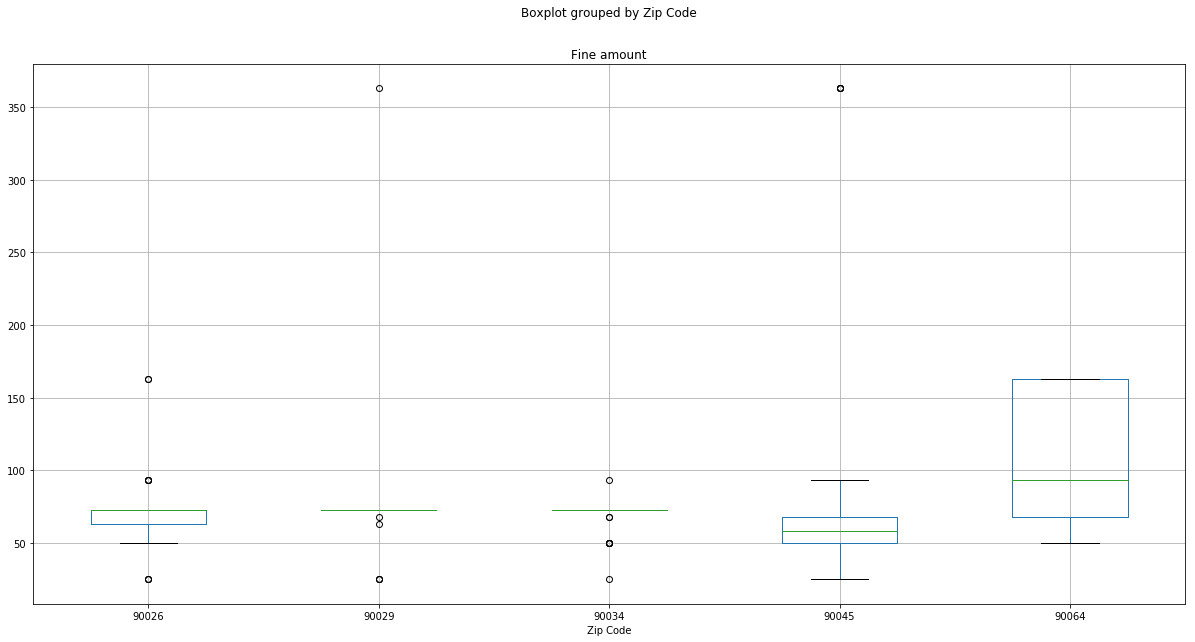

In [50]:
# Boxplot to visual the data
zip_code_analysis.boxplot('Fine amount', by="Zip Code", figsize=(20, 10))
plt.savefig('BoxPlotANOVA.png')

In [53]:
# Extract individual groups
group1 = zip_code_analysis[zip_code_analysis["Zip Code"] == 90034]["Fine amount"]
group2 = zip_code_analysis[zip_code_analysis["Zip Code"] == 90045]["Fine amount"]
group3 = zip_code_analysis[zip_code_analysis["Zip Code"] == 90064]["Fine amount"]
group4 = zip_code_analysis[zip_code_analysis["Zip Code"] == 90026]["Fine amount"]
group5 = zip_code_analysis[zip_code_analysis["Zip Code"] == 90029]["Fine amount"]

In [54]:
# the ANOVA
# Hypothesis was there is no difference of fine amounts between zip codes
# with a pvalue of 1.213 x 10^-5 or 0.00001213 there is a statistcally significant difference 
# in the fine amounts of top five zip code

stats.f_oneway(group1, group2, group3, group4, group5)

F_onewayResult(statistic=7.320251248843173, pvalue=1.1152908940432792e-05)

## Conclusion: There is a statistical difference in the zip codes for the top five for fine amounts. Reject the null hypothesis. 